In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from matplotlib import cm
from scipy.integrate import dblquad
import sympy
import numpy as np
from tqdm import tqdm
import scipy.stats
import random

# Define function

In [3]:
def load_vadere(df, scale, start_frame, end_frame, frame_skip):
    nPed = int(df['pedestrianId'].max())
    df['pedestrianId'] -= 1 # PID start with 0
    X = np.full((nPed,end_frame),np.nan)  # (pid,frame),  x == nan means the person is not in the field
    Y = np.full((nPed,end_frame),np.nan)  # (pid,frame)
    for pid,tid,st,et,sx,ex,sy,ey in tqdm(zip(df['pedestrianId'],df['targetId-PID2'],df['simTime'],df['endTime-PID1'],df['startX-PID1'],df['endX-PID1'],df['startY-PID1'],df['endY-PID1']),total=df.shape[0]):
        pid = int(pid)
        start_fr = max(int(round(st/frame_skip)),start_frame)
        end_fr = min(int(round(et/frame_skip))+1,end_frame)
        if end_fr-start_fr>0:
            X[pid,start_fr:end_fr] = np.linspace(sx,ex, end_fr-start_fr)
            Y[pid,start_fr:end_fr] = np.linspace(sy,ey, end_fr-start_fr)
    return(scale*X,scale*Y)

def compute_velocity(X, Y, noise_std):
    # Adding Gaussian noise
    df_x = X + np.random.normal(0,noise_std,size=(X.shape))
    df_y = Y + np.random.normal(0,noise_std,size=(Y.shape))
    # Delete singular points on simulation data(entrance, exit)
    del_idx = np.where( np.logical_or(df_y > 45, df_y < 5) )
    df_x[del_idx] = np.nan
    df_y[del_idx] = np.nan
    # velocity data
    df_u = np.roll(df_x,1)-df_x
    df_v = np.roll(df_y,1)-df_y
    df_norm = np.sqrt(df_u**2 + df_v**2)
    # If velocity is equal to 0(or less than std of noise), it takes former velocity
    for j in range(len(df_u[0])):
        small_v_idx = np.where(df_norm[:,j] <= noise_std)
        if len(small_v_idx[0])>0:
            df_u[small_v_idx,j] = df_u[small_v_idx,j-1]
            df_v[small_v_idx,j] = df_v[small_v_idx,j-1]
    df_norm = np.sqrt(df_u**2 + df_v**2)
    # normalize velocity
    df_u_normal = df_u / df_norm
    df_v_normal = df_v / df_norm
    # normalized velocity data for 2nd trigonometic moment
    df_u2 = df_u**2 - df_v**2
    df_v2 = 2*df_u*df_v
    return(df_x,df_y,df_u,df_v,df_norm,df_u_normal,df_v_normal,df_u2,df_v2)

def indicator_each(U,V,U2,V2,const,length,time):
    # data for function "f" at target frame range
    U_f = U[:,time-length:time+1]
    V_f = V[:,time-length:time+1]
    U2_f = U2[:,time-length:time+1]
    V2_f = V2[:,time-length:time+1] 
    # indicator: function "f"
    indicator_f_r1 = np.sqrt(np.sum(U_f,axis=1)**2 + np.sum(V_f,axis=1)**2) / (length+1)
    indicator_f_r2 = np.sqrt(np.sum(U2_f,axis=1)**2 + np.sum(V2_f,axis=1)**2) / (length+1)
    indicator_f = (1-indicator_f_r1)**const * (1-indicator_f_r2)**(1-const)
    return(indicator_f)

def indicator_all(U,V,U2,V2,const,time):
    # data for function "f" at target frame range
    U_g = U[:,time]
    V_g = V[:,time]
    U2_g = U2[:,time]
    V2_g = V2[:,time]
    mask = ~np.isnan(U_g)
    U_g = U_g[mask]
    V_g = V_g[mask]
    U2_g = U2_g[mask]
    V2_g = V2_g[mask]    
    # indicator: function "g"
    if len(U_g) == 0:
        indicator_g = 0
    else:
        indicator_g_r1 = np.sqrt(np.sum(U_g)**2 + np.sum(V_g)**2) / len(U_g)
        indicator_g_r2 = np.sqrt(np.sum(U2_g)**2 + np.sum(V2_g)**2) / len(U2_g)       
        indicator_g = 1 - (const*indicator_g_r1 + (1-const)*indicator_g_r2) 
    return(indicator_g)

# Data

In [4]:
scale = 1
start_frame = 0
end_frame = 500
frame_skip = 1

# shopping ratio test data
df_list = []
for i in range(5,6):
    df_list.append(pd.read_csv('data/500fr_ratio_test/{}%.txt'.format(10*i),header=0,delim_whitespace=True,dtype='f8'))
#names = [10*i for i in range(11)]

coords = [load_vadere(df, scale, start_frame, end_frame, frame_skip) for df in df_list]


100%|█████████████████████████████████████████████████████████████████████████| 86921/86921 [00:03<00:00, 23212.68it/s]


# Nigiwai indicator

In [5]:
# Parameters, df, ROI
roi_den_x = 22
roi_den_y = 50
cutoff_dist = 2
cutoff_ped_number = 0

# parameters for indicators
fr_number = 9 # number of velocity data for calculation of randomness of each ped
weight_r1_each = 0.5 # constant for weight of R_1
weight_r1_all = 0 # constant for weight of R_1
weight_all = 0 # constant for weight of indicator_all
weight_entropy = 0 # constant for weight of entropy in indicator_each_ped
noise_std = 0.01 # std of noise

In [6]:
# ROI map
roi_x0 = np.linspace(0, scale * 22, roi_den_x)
roi_y0 = np.linspace(0, scale * 50, roi_den_y)

roi_x, roi_y = np.meshgrid(roi_x0, roi_y0)
roi_xy = np.vstack([roi_x.ravel(), roi_y.ravel()]).T

100%|█████████████████████████████████████████████████████████████████████████| 86921/86921 [00:03<00:00, 22722.33it/s]
<ipython-input-3-76c2f38888ff>:51: RuntimeWarning: invalid value encountered in sqrt
  indicator_f = (1-indicator_f_r1)**const * (1-indicator_f_r2)**(1-const)


Frame number: 100
average number of neighbours: 1.0363636363636364
Frame number: 101
average number of neighbours: 1.06
Frame number: 102
average number of neighbours: 1.059090909090909
Frame number: 103
average number of neighbours: 1.0618181818181818
Frame number: 104
average number of neighbours: 1.0363636363636364


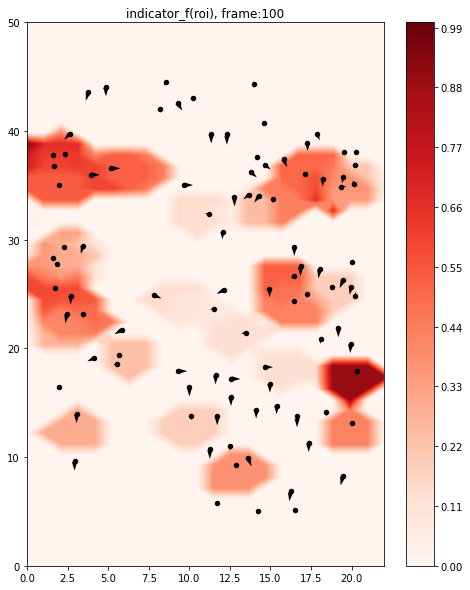

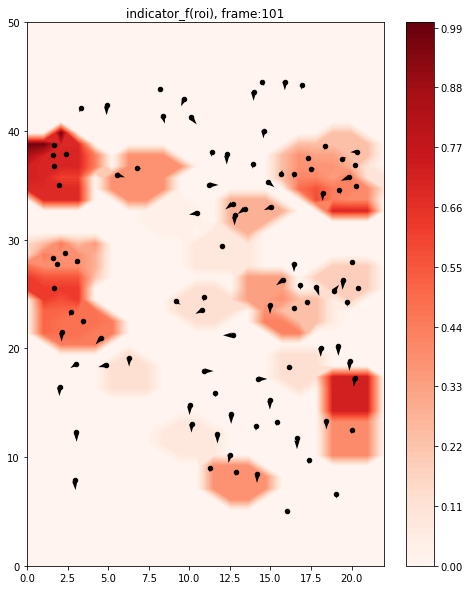

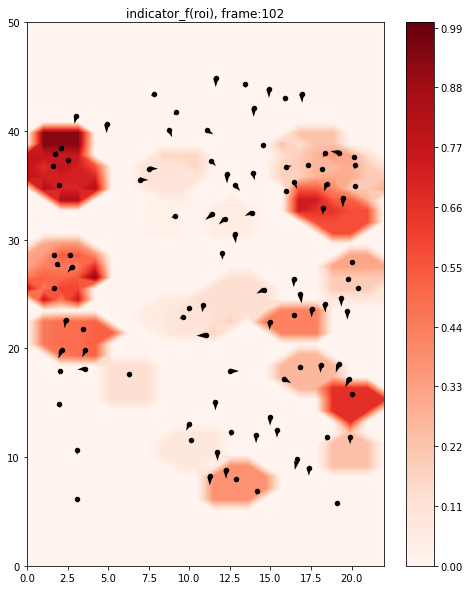

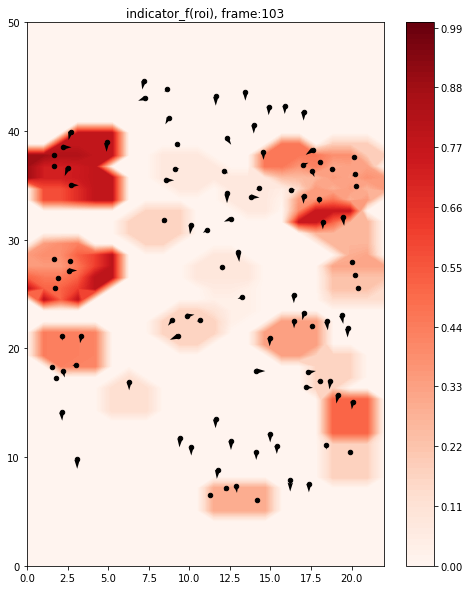

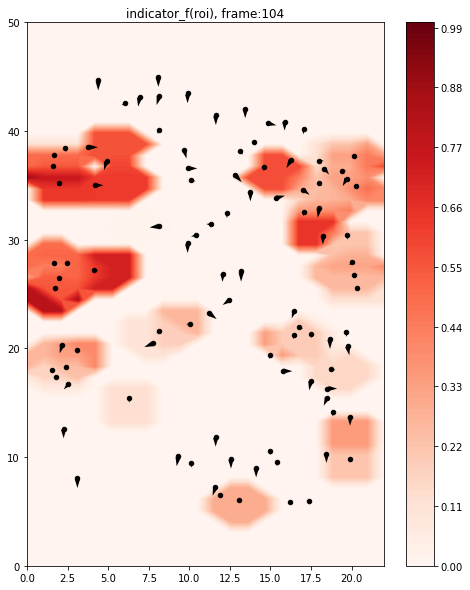

In [11]:
df = df_list[0]
df_vadere = load_vadere(df, scale, start_frame, end_frame, frame_skip)

df_x,df_y,df_u,df_v,df_norm,df_u_normal,df_v_normal,df_u2,df_v2 = compute_velocity(df_vadere[0], df_vadere[1], noise_std)

for target_fr in range(100, 105):
    print("Frame number:", target_fr)
    
    # Calculate indicator
    indicator_roi_arr = np.zeros((len(roi_xy)))
    n_neighbour = 0
    
    indicator_f = indicator_each(df_u,df_v,df_u2,df_v2,weight_r1_each,fr_number, target_fr)
    
    for i in range(len(roi_xy)):
        col_dist = np.sqrt((df_x[:,target_fr] - roi_xy[i][0])**2 + (df_y[:,target_fr] - roi_xy[i][1])**2)
        nei_index = np.where(col_dist < cutoff_dist)[0]       
        n_neighbour += len(nei_index)
        
        indicator_f_roi = indicator_f[nei_index][~np.isnan(indicator_f[nei_index])]
        if len(indicator_f_roi) > cutoff_ped_number:
            indicator_roi_arr[i] = indicator_f_roi.mean()
        
    print("average number of neighbours:", n_neighbour/len(roi_xy))
    
    indicator_roi_arr_df = []
    for i in range(len(indicator_roi_arr)//roi_den_x):
        indicator_roi_arr_df.append(indicator_roi_arr[i*roi_den_x : (i+1)*roi_den_x])
    
    # Draw picture
    plt.figure(figsize=(8, 10))
    plt.title('indicator_f(roi), frame:{}'.format(target_fr))
    levels = np.linspace(0, 1, 101)
    cntr = plt.contourf(roi_x, roi_y, indicator_roi_arr_df, levels=levels, cmap=cm.Reds)
    plt.scatter(df_x[:,target_fr-1], df_y[:,target_fr-1], s=20, c='k')
    plt.quiver(df_x[:,target_fr-1], df_y[:,target_fr-1], -df_u[:,target_fr], -df_v[:,target_fr], width=0.005, color='k')
    #curl_cntr.set_clim(0, 0.5)
    plt.colorbar(cntr)